<a href="https://colab.research.google.com/github/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification to detect sensitive data exposure

## Importing libraries and downloading the dataset

In [4]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import os

# Downloading the dataset
git_folder = "/content/Detection-of-Sensitive-Data-Exposure-in-Images"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/SaifulJnU/Detection-of-Sensitive-Data-Exposure-in-Images.git
training_folder = git_folder + "/dataset/training"
validation_folder = git_folder + "/dataset/validation"

Cloning into 'Detection-of-Sensitive-Data-Exposure-in-Images'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (651/651), done.
remote: Compressing objects: 100% (649/649), done.
remote: Total 651 (delta 0), reused 648 (delta 0), pack-reused 0
Receiving objects: 100% (651/651), 6.88 MiB | 43.74 MiB/s, done.


In [5]:
train_sensitive_dir = os.path.join(training_folder + "/sensitive")
train_nonsensitive_dir = os.path.join(training_folder + "/nonsensitive")
validation_sensitive_dir = os.path.join(validation_folder + "/sensitive")
validation_nonsensitive_dir = os.path.join(validation_folder + "/nonsensitive")

# Image Dataset size
print('Total training sensitive images:', len(os.listdir(train_sensitive_dir)))
print('Total training nonsensitive images:', len(os.listdir(train_nonsensitive_dir)))
print('Total validation sensitive images:', len(os.listdir(validation_sensitive_dir)))
print('Total validation nonsensitive images:', len(os.listdir(validation_nonsensitive_dir)))

Total training sensitive images: 310
Total training nonsensitive images: 254
Total validation sensitive images: 45
Total validation nonsensitive images: 30


## Sample Data

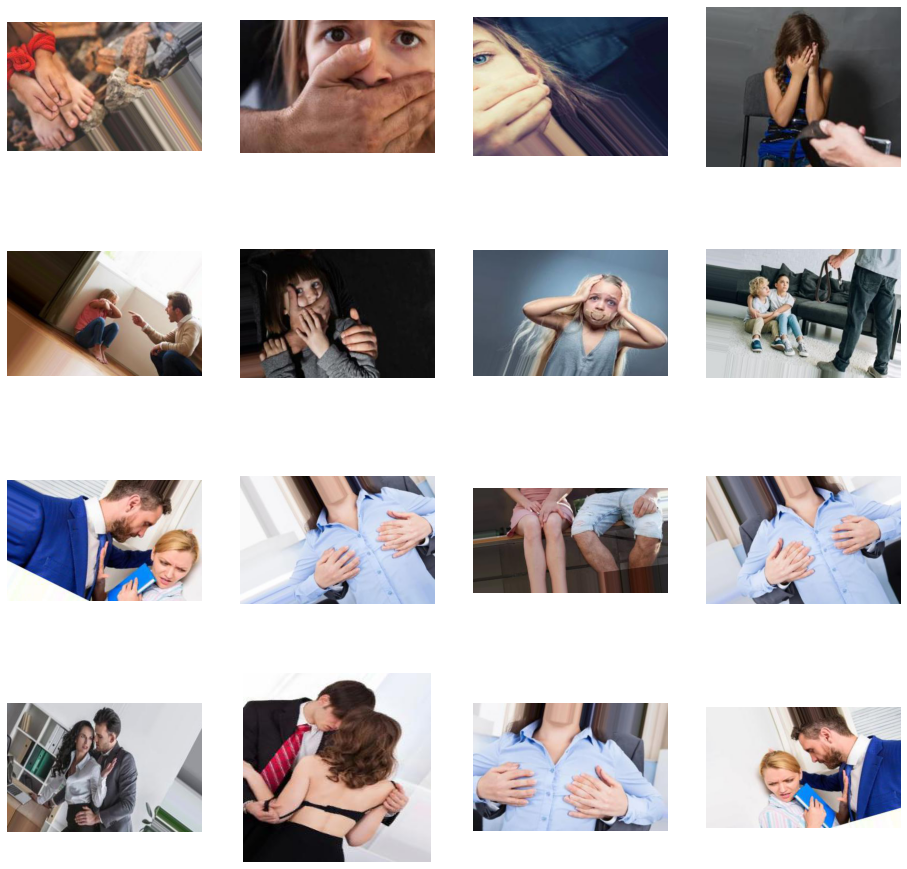

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_sensitive_dir = os.path.join(training_folder+"/sensitive")
train_nonsensitive_dir = os.path.join(training_folder+"/nonsensitive")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname) 
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname) 
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Model

In [7]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.98

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 98% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.models.Sequential([
  # 2D Convolution Layer - Filter, Kernel_size, activation fn
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  # Max pooling operation for 2D data - Pool size
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flattens the input. Does not affect the batch size.
  tf.keras.layers.Flatten(),
  # Regular densely-connected Neural Network layer with ReLU activation function.
  tf.keras.layers.Dense(512, activation='relu'),
  # Regular densely-connected Neural Network layer with sigmoid activation function.
  tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Preprocessing, Data Augmentation & Training

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling - 1/255 is to transform every pixel value from range [0,255] -> [0,1]
# Performing image augmentation for training data
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# flow_from_directory - Takes the path to a directory & generates batches of data.
train_generator = train_datagen.flow_from_directory(
        training_folder,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary',
        shuffle=True
       )

validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary',
        shuffle=True
        )

num_epochs = 500
# model.fit - Train the model for a fixed number of epochs
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=num_epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[callbacks])

Found 564 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Epoch 1/500
10/10 [==============================] - 12s 214ms/step - loss: 0.8175 - accuracy: 0.5167 - val_loss: 0.6892 - val_accuracy: 0.6000
Epoch 2/500
10/10 [==============================] - 2s 201ms/step - loss: 0.6943 - accuracy: 0.5067 - val_loss: 0.6903 - val_accuracy: 0.5250
Epoch 3/500
10/10 [==============================] - 2s 230ms/step - loss: 0.6927 - accuracy: 0.5034 - val_loss: 0.6891 - val_accuracy: 0.6750
Epoch 4/500
10/10 [==============================] - 2s 200ms/step - loss: 0.6906 - accuracy: 0.5700 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 5/500
10/10 [==============================] - 2s 201ms/step - loss: 0.6662 - accuracy: 0.6200 - val_loss: 0.7098 - val_accuracy: 0.4750
Epoch 6/500
10/10 [==============================] - 2s 202ms/step - loss: 0.6295 - accuracy: 0.6067 - val_loss: 0.7223 - val_accuracy: 0.5500
Epoch 7/500
10/10 [==============================] - 2s 201m

## Plotting Accuracy and Loss Functions

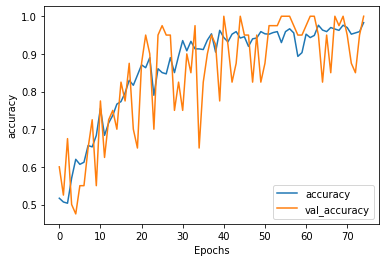

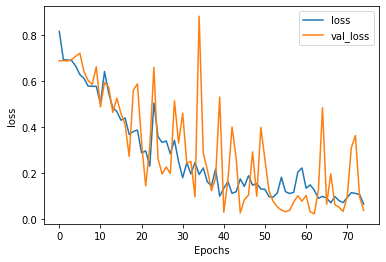

In [9]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix

Confusion Matrix
Accuracy for 18 Test Data =  58.82352941176471
Accuracy for 37 Test Data =  51.35135135135135
Accuracy for 56 Test Data =  54.71698113207547
Accuracy for 75 Test Data =  52.38095238095239


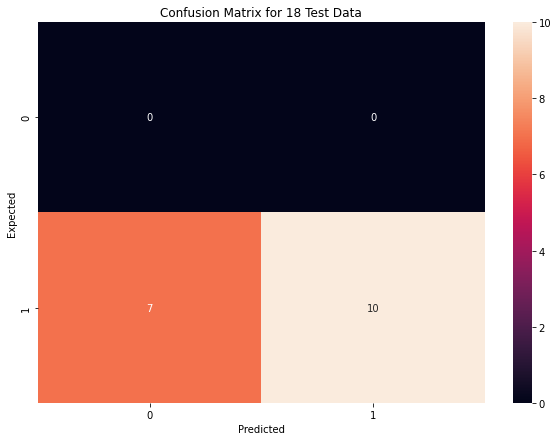

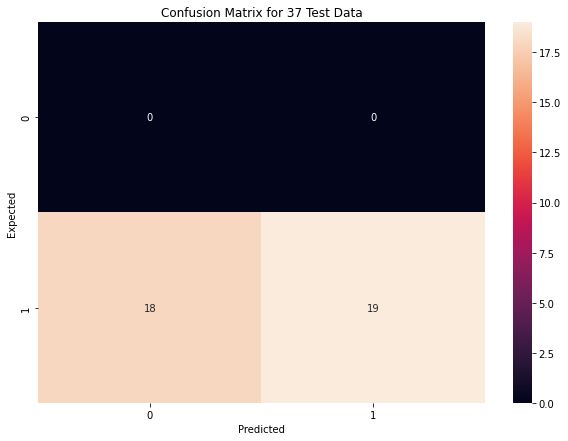

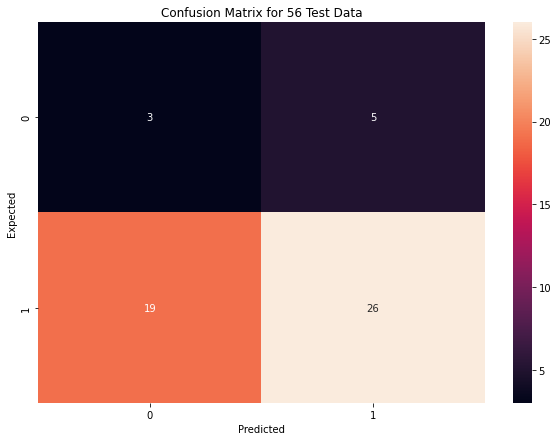

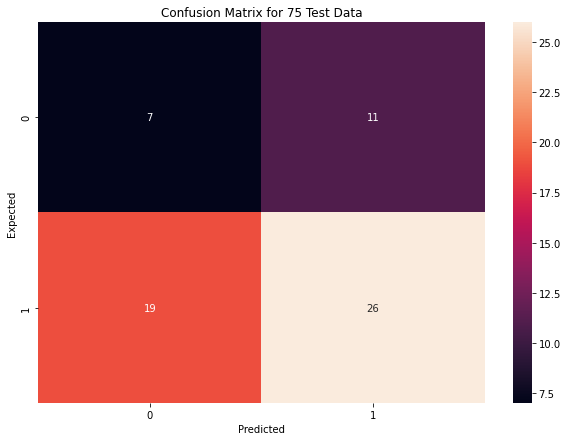

In [10]:
import seaborn
y_pred = model.predict(validation_generator, 20)
print('Confusion Matrix')
y_predicted_labels = y_pred > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  mid = 49
  start = mid-((total+1)//2)+1
  end = mid+((total+1)//2)
  cm = tf.math.confusion_matrix(labels=validation_generator.labels[start:end],predictions=y_predicted_labels[start:end])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

## Saving the model

In [11]:
# Save and convert the model (Used for deploying in web application)
model.save('model/image_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/image_model.h5 /content/image_model
print("Model converted to JSON successfully")

Saved the model successfully
Selecting previously unselected package python-pip-whl.
(Reading database ... 123934 files and directories currently installed.)
Preparing to unpack .../python-pip-whl_9.0.1-2.3~ubuntu1.18.04.5_all.deb ...
Unpacking python-pip-whl (9.0.1-2.3~ubuntu1.18.04.5) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../python3-pkg-resources_39.0.1-2_all.deb ...
Unpacking python3-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python3-virtualenv.
Preparing to unpack .../python3-virtualenv_15.1.0+ds-1.1_all.deb ...
Unpacking python3-virtualenv (15.1.0+ds-1.1) ...
Selecting previously unselected package virtualenv.
Preparing to unpack .../virtualenv_15.1.0+ds-1.1_all.deb ...
Unpacking virtualenv (15.1.0+ds-1.1) ...
Setting up python-pip-whl (9.0.1-2.3~ubuntu1.18.04.5) ...
Setting up python3-pkg-resources (39.0.1-2) ...
Setting up python3-virtualenv (15.1.0+ds-1.1) ...
Setting up virtualenv (15.1.0+ds-1.1) ...
P

## Sample Example

Saving sh_0_463.jpeg to sh_0_463 (1).jpeg
[0.]
sh_0_463.jpeg - Sexual harassment


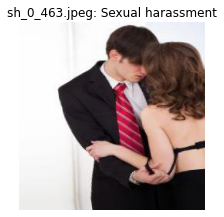

In [18]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Child abusing")
    result[fn] = "Child abusing"
  else:
    print(fn + " - Sexual harassment")
    result[fn] = "Sexual harassment"

plt.figure(figsize=(20,20))
   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)